In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy
import time

from funcs.model import (full_model,
                         aflare,
                         calculate_specific_flare_flux,
                         calculate_angular_radius)
from funcs.multiperiod import remove_sinusoidal
from funcs.helper import fetch_lightcurve


CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

#-----------------------------------
import numpy as np
import pandas as pd

from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve


# Different flare/active region configurations have different numbers of parameters
log_probs = {"log_probability": 6, # one flare, one active region
             "log_probability_2flares": 9, # two flares, one active region
            }

# Create a time stamp for this run
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())


In [2]:
tstamp

'03_10_2020_11_23'

In [3]:
# Read in target parameters
# ALL TARGETS MUST BE DEFINED IN THIS TABLE AND HAVE LIGHT CURVE
# OTHERWISE NOTHING WILL WORK
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")

# Choose target from table
target_N = 2
target = lcs.iloc[target_N]

# Pick up inclination and uncertainty
i_mu, i_sigma = target.i_mu, target.i_sigma

# Pick up quiescent luminosity
qlum = target.tlum * u.erg/u.s

# Pick up stellar radius
R = target.rad * R_sun

target

ID                     44984200
QCS                          10
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                   custom
h_mission                  TESS
SpT                          M6
view_start              1587.25
view_stop               1589.75
view_min                   1620
view_max                   2200
BJDoff                  2457000
tstart                  1588.03
ampl_min                    0.5
ampl_max                    0.8
GRP                        1.54
plxmas                  90.0357
eplxmas                0.222697
RA                      129.508
Dec                    -58.9331
J                        10.309
R                         15.08
Gaia_G                  14.4115
vsini_kms                  34.8
e_vsini_kms                 0.8
Prot_d                    0.113
sini                        NaN
Ref                   this work
identifier       SCR J0838-5855
Rstar   

In [4]:

# Get the light curve of the target
# from a pre-defined path
flck = fetch_lightcurve(target)

# We are dealing with ultrafast rotators witha simple sinusoidal signal
t, sflux, model, period = remove_sinusoidal(target, plot=False, save=False)

# define flare light curve so that you can use find_iterative_median later
flcd = FlareLightCurve(time=t, 
                       detrended_flux=sflux, 
                       detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))


# Choose the light curve range to use for the model fit
choice = (t > target.view_start +.1) & (t < target.view_stop-.1) 
t = t[choice]
flux = sflux[choice]

# Define the flux error
flux_err = np.nanmean(flcd.detrended_flux_err)

# Find the median flux in the chosen light curve range
# by clipping outliers iteratively
flcd = flcd[choice]
median = np.nanmean(find_iterative_median(flcd).it_med)


# Convert time array to rotation phase array
# using the rotation period of the star
phi = (t - t[0]) / target.Prot_d * 2 * np.pi

TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03


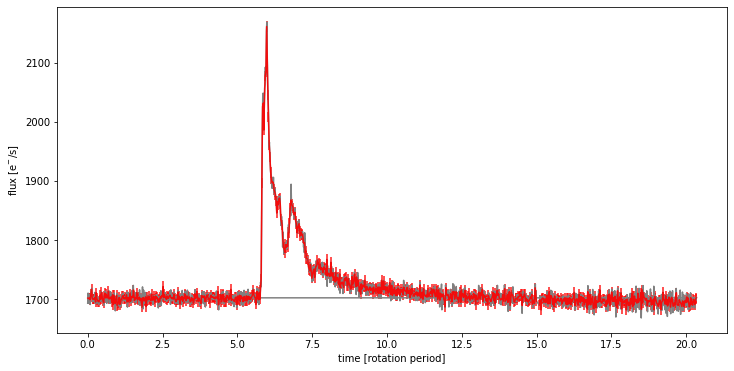

In [7]:

cf = pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median})
cff = cf.groupby(pd.cut(cf.phi, 900)).apply(np.mean)
plt.figure(figsize=(12,6))
plt.plot(cf.phi/(2*np.pi), cf.flux,color="grey")
plt.errorbar(cff.phi/(2*np.pi), cff.flux, yerr=cff.flux_err, color="r", alpha=.9)
plt.plot(cf.phi/(2*np.pi), [median]*len(cf.phi),color="grey")
plt.xlabel("time [rotation period]")
plt.ylabel(r"flux [e$^{-}$/s]");
#plt.xlim(25,30)

In [8]:
#cff = cff[(cff.phi<18.7) |(cff.phi>19.6)]
cff

,phi,flux,t,flux_err,median_
phi,,,,,
"(-0.128, 0.142]",0.038613,1701.529280,1587.350808,8.676423,1702.058805
"(0.142, 0.284]",0.193065,1700.856538,1587.353585,8.676423,1702.058805
"(0.284, 0.426]",0.347517,1701.709507,1587.356363,8.676423,1702.058805
"(0.426, 0.568]",0.501969,1698.949898,1587.359141,8.676423,1702.058805
"(0.568, 0.71]",0.656420,1708.136879,1587.361918,8.676423,1702.058805
...,...,...,...,...,...
"(127.099, 127.241]",127.152395,1699.564822,1589.636886,8.676423,1702.058805
"(127.241, 127.383]",127.306846,1698.084112,1589.639664,8.676423,1702.058805
"(127.383, 127.525]",127.461298,1690.757885,1589.642442,8.676423,1702.058805


In [9]:
# Write out light curve to use for MCMC fit
cff = cff.dropna(how="any")
cff.to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv", index=False)

In [10]:
tstamp

'03_10_2020_11_24'

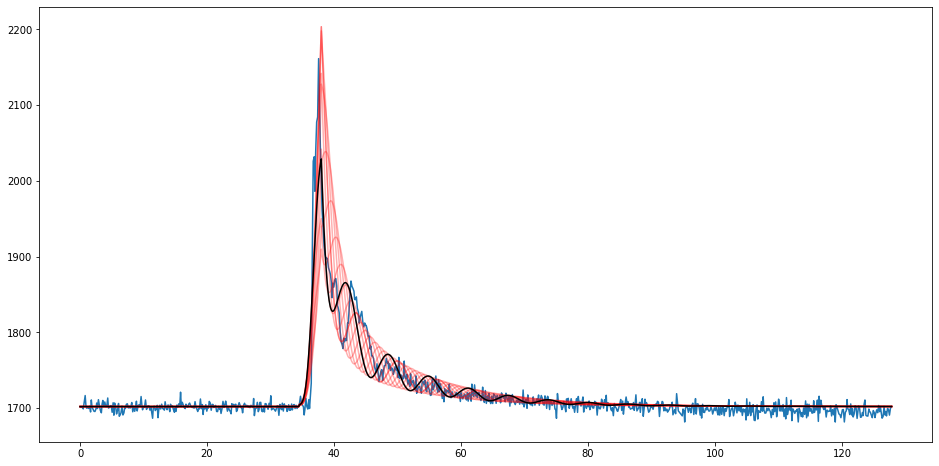

In [11]:
# Play with parameters to get a first guess for the MCMC 
# When fitting more than one flare, do one flare first, then the next etc.

# Flare peak time
phi_a =38

# Active region latitude
theta_a = 1.

# Flare amplitude
a = 0.3

# 2*FWHM of flare
fwhm =  7


phi0 =4.8
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
#plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
#theta_a, i_mu, phi_a, radius



plt.figure(figsize=(16,8))
plt.plot(cff.phi,cff.flux)
for i in np.linspace(-2*np.pi,2*np.pi,10):
    plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,);
# plt.xlim(1331,1333.25)
#plt.ylim(608,900)

In [12]:
# Choose model:
log_prob = "log_probability"#_2flares"
nparam = log_probs[log_prob]


# Save starting points and parameters for MCMC
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = ("date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,"\
                "i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,"\
                "median,log_prob,nparam\n")
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},"\
           f"{median},{log_prob},{nparam}\n")
   # f.write(firstout)
    f.write(out)